In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.3
IPython 7.4.0

numpy 1.14.5
scipy 1.3.1
pandas 0.24.2
matplotlib 3.0.3
statsmodels 0.9.0
sklearn 0.20.3

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-46-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   :


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import itertools
import os
from glob import glob
import numpy as np
import pandas as pd
import copy
from collections import Counter, deque
import datetime
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix, hstack
import concurrent.futures
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import LinearSVC

In [4]:
PATH_TO_DATA = 'data/'

# 1 Обучение модели

## 1.1 Выбор модели

Будем сравнивать модели на данных для 10 пользователей. Загружем сохраненную ранее разряженную матрицу. Сначала рассмотрим только базовые признаки сессий, т.е. те, которые получены с помощью модели мешка слов.

In [5]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_10users_s10_w10.pkl'), 'rb') as file_obj:
    X_sparse = pickle.load(file_obj)
with open(os.path.join(PATH_TO_DATA, 'y_10users_s10_w10.pkl'), 'rb') as file_obj:
    y = pickle.load(file_obj)

Для оценки будем использовать кросс-валидацию с 3 фолдами.

In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, test_size=0.3, 
                                                    random_state=17, stratify=y)

Обучим следующие алгоритмы классификации:
- k-ближайших соседей
- Случайный лес
- Логистическая регрессия
- Линейный SVM

**k-ближайших соседей**

In [8]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1) 

print( 'Доля верных предсказаний KNeighborsClassifier на кросс-валидации: %.3f' %
       cross_val_score(knn, X_train, y_train, cv=skf, n_jobs=-1).mean() )

print( 'Доля верных предсказаний KNeighborsClassifier на валидации: %.3f' %
       accuracy_score(y_valid, knn.fit(X_train, y_train).predict(X_valid)) )

Доля верных предсказаний KNeighborsClassifier на кросс-валидации: 0.565
Доля верных предсказаний KNeighborsClassifier на валидации: 0.584


**Случайный лес**

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)

print( 'Доля верных предсказаний RandomForestClassifier на кросс-валидации: %.3f' %
       cross_val_score(rf, X_train, y_train, cv=skf, n_jobs=-1).mean() )

print( 'Доля верных предсказаний RandomForestClassifier на валидации: %.3f' %
       accuracy_score(y_valid, rf.fit(X_train, y_train).predict(X_valid)) )

Доля верных предсказаний RandomForestClassifier на кросс-валидации: 0.712
Доля верных предсказаний RandomForestClassifier на валидации: 0.735


**Логистическая регрессия**

In [10]:
log_reg = LogisticRegression(random_state=17, n_jobs=-1, solver='lbfgs', multi_class='multinomial')

print( 'Доля верных предсказаний LogisticRegression на кросс-валидации: %.3f' %
       cross_val_score(log_reg, X_train, y_train, cv=skf, n_jobs=-1).mean() )

print( 'Доля верных предсказаний LogisticRegression на валидации: %.3f' %
       accuracy_score(y_valid, log_reg.fit(X_train, y_train).predict(X_valid)) ) 

Доля верных предсказаний LogisticRegression на кросс-валидации: 0.759
Доля верных предсказаний LogisticRegression на валидации: 0.777


Для логистической регрессии подберем оптимальное значение коэффициента регуляризации `C`.

In [11]:
logit_c_values = np.linspace(0.5, 1.5, 50)

logit_grid_searcher = LogisticRegressionCV( Cs=logit_c_values,
                                            solver='lbfgs',
                                            cv=skf,
                                            n_jobs=-1,
                                            multi_class='multinomial',
                                            random_state=17)
logit_grid_searcher.fit(X_train, y_train)
logit_mean_cv_scores = logit_grid_searcher.scores_.popitem()[1].mean(axis=0)

print('Лучшее значение параметра C для модели LogisticRegression: %.3f' %
      logit_grid_searcher.Cs_[np.argmax(logit_mean_cv_scores)])

print('Доля верных предсказаний лучшей модели LogisticRegression на кросс-валидации: %.3f' % 
       np.max(logit_mean_cv_scores))

print('Доля верных предсказаний лучшей модели LogisticRegression на валидации: %.3f' %
      accuracy_score(y_valid, logit_grid_searcher.predict(X_valid)) )

Лучшее значение параметра C для модели LogisticRegression: 0.929
Доля верных предсказаний лучшей модели LogisticRegression на кросс-валидации: 0.759
Доля верных предсказаний лучшей модели LogisticRegression на валидации: 0.776


**Линейный SVM**

In [12]:
svc = LinearSVC(C=1.0, random_state=17)

print('Доля верных предсказаний LinearSVC на кросс-валидации: %.3f' %
      cross_val_score(svc, X_train, y_train, cv=skf, n_jobs=-1).mean() )

print('Доля верных предсказаний LinearSVC на валидации: %.3f' %
      accuracy_score(y_valid, svc.fit(X_train, y_train).predict(X_valid)) )

Доля верных предсказаний LinearSVC на кросс-валидации: 0.753
Доля верных предсказаний LinearSVC на валидации: 0.777


Для SVM проведем подбор оптимального параметра регуляризации C.

In [13]:
logit_c_values1 = np.linspace(0.01, 0.5, 100)

svс_grid_searcher = GridSearchCV(LinearSVC(random_state=17),
                                 param_grid={'C': logit_c_values1},
                                 n_jobs=-1,
                                 cv=skf)

svс_grid_searcher.fit(X_train, y_train)

print('Лучшее значение параметра C для модели LinearSVC: %.3f' % svс_grid_searcher.best_params_['C'])
print('Доля верных предсказаний лучшей модели LinearSVC на кросс-валидации: %.3f' % 
       svс_grid_searcher.best_score_)
print('Доля верных предсказаний лучшей модели LinearSVC на валидации: %.3f' %
       accuracy_score(y_valid, svс_grid_searcher.predict(X_valid)) )

Лучшее значение параметра C для модели LinearSVC: 0.104
Доля верных предсказаний лучшей модели LinearSVC на кросс-валидации: 0.765
Доля верных предсказаний лучшей модели LinearSVC на валидации: 0.781


Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).

In [14]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

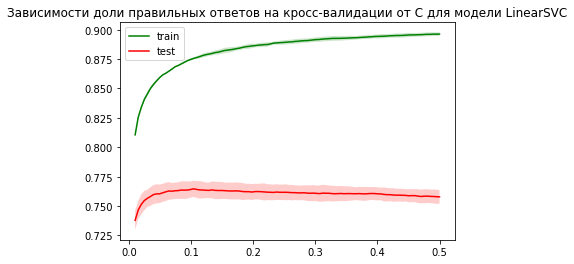

In [15]:
plot_validation_curves( list(svс_grid_searcher.cv_results_['param_C']),
                        svс_grid_searcher.cv_results_)
plt.title('Зависимости доли правильных ответов на кросс-валидации от С для модели LinearSVC');

На признаках, полученных с помощью модели мешка слов на данных для 10 пользователей, лучшее качество показывают линейные модели: `LinearSVC` и `LogisticRegression`. `RandomForestClassifier` показал результат ниже, т.к. деревянные модели плохо работают с разреженными данными.

## 2.2 Подбор параметров: длинна сессии и ширина окна

Подбор будем осуществлять с помощью модели `LinearSVC`, показавшей лучшее качество на кросс-валидации для длинны сессии и ширины окна 10 на данных для 10 пользователей. Реализована функция `model_assessment`, рассчитывающая долю верных ответов на кросс-валидации и на отложенной выборке.

In [16]:
def model_assessment(estimator, X, y, cv, seed=17, test_size=0.3):    
    estimator1 = copy.deepcopy(estimator)
    estimator2 = copy.deepcopy(estimator)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, 
                                                          random_state=seed, stratify=y)
    
    def accuracy_score_task():
        return accuracy_score(y_valid, estimator2.fit(X_train, y_train).predict(X_valid))    
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        accuracy_score_future = executor.submit(accuracy_score_task)
        return cross_val_score(estimator1, X_train, y_train, cv=cv, n_jobs=-1)\
               .mean(),accuracy_score_future.result()

In [17]:
estimator = svс_grid_searcher.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, window_size))
        
        with open(path_to_X_pkl, 'rb') as file_obj:
            X_sparse = pickle.load(file_obj)
        
        with open(path_to_y_pkl, 'rb') as file_obj:
            y = pickle.load(file_obj)
        
        result = model_assessment(estimator, X_sparse, y, skf)
        print( 'session_length =', session_length,
               '; window_size =', window_size,
               '; train:', round(result[0], 3),
               '; val:', round(result[1], 3) )

session_length = 15 ; window_size = 10 ; train: 0.824 ; val: 0.84
session_length = 10 ; window_size = 10 ; train: 0.765 ; val: 0.781
session_length = 15 ; window_size = 7 ; train: 0.848 ; val: 0.854
session_length = 10 ; window_size = 7 ; train: 0.797 ; val: 0.807
session_length = 7 ; window_size = 7 ; train: 0.753 ; val: 0.762
session_length = 15 ; window_size = 5 ; train: 0.868 ; val: 0.875
session_length = 10 ; window_size = 5 ; train: 0.816 ; val: 0.825
session_length = 7 ; window_size = 5 ; train: 0.774 ; val: 0.785
session_length = 5 ; window_size = 5 ; train: 0.725 ; val: 0.736


**Результат**
<br> Лучшее качество модель демонстрирует при разбиении данных на сессии с параметрами `session_length=15` и `window_size=5`:
- Доля верных предсказаний на кросс-валидации: 0.868
- Доля верных предсказаний на отложенной выборке: 0.875

## 2.3. Влияние дополнительных признаков
Исследуем влияние дополнительных признаков при разбиении данных на сессии с параметрами `session_length=15` и `window_size=5`.

In [18]:
def read_lines(file_obj, site_freq, buffer, n):
    for i in range(n):
        line = file_obj.readline()
        if not line:
            buffer.extend([(None, 0)] * (n - i))    
            return i
        
        comma_index = line.index(',')
        timestamp = line[:comma_index]
        site_url = line[comma_index + 1:-1]
        buffer.append((datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S'), site_freq[site_url][0]))
    
    return n


def feature_engineering(path_to_csv_files, foldname, site_freq_path, features, 
                        session_length=10, window_size=10):
    
    def extract_time_of_day(timestamp):
        return timestamp.hour // 6


    def build_row_feature_engineering(buffer, n, user_id, top_sites):
        session_sites = [data[1] for data in buffer]
        session_timespan = (buffer[n - 1][0] - buffer[0][0]).total_seconds()
        unique_sites = set(session_sites)
        unique_sites.discard(0)
        start_hour = buffer[0][0].hour
        day_of_week = buffer[0][0].weekday()
        time_of_day = extract_time_of_day(buffer[0][0])

        assert n > 1
        average_visit_duration = session_timespan / (n - 1)

        session_sites_frequencies = Counter(session_sites)
        session_sites_frequencies.pop(0, None)
        max_frequency = session_sites_frequencies.most_common(1)[0][1] / n

        top_sites_visits = 0
        for site in session_sites:
            if site in top_sites:
                top_sites_visits += 1

        top_sites_visits /= n

        session_sites.append(session_timespan)
        session_sites.append(len(unique_sites))
        session_sites.append(start_hour)
        session_sites.append(day_of_week)
        session_sites.append(time_of_day)
        session_sites.append(average_visit_duration)
        session_sites.append(max_frequency)
        session_sites.append(top_sites_visits)
        session_sites.append(user_id)

        return session_sites
    
    with open(site_freq_path, 'rb') as file_obj:
        site_freq = pickle.load(file_obj)
    
    top_sites = set(list(zip(*sorted(site_freq.values(), key=lambda x: x[1])[-30:]))[0])
    buffer = deque(maxlen=session_length)
    data = []
    user_id = 1
    for file_path in sorted(glob(os.path.join(path_to_csv_files, foldname, '*.csv'))):
        with open(file_path, 'r') as file_obj:
            file_obj.readline()
            n = read_lines(file_obj, site_freq, buffer, session_length)
            if n > 0:
                data.append(build_row_feature_engineering(buffer, n, user_id, top_sites))
                
                while True:
                    n -= window_size - read_lines(file_obj, site_freq, buffer, window_size)
                    if n <= 0:
                        break
                    
                    if n == 1:
                        continue
                    
                    data.append(build_row_feature_engineering(buffer, n, user_id, top_sites))
        
        user_id += 1
    
    return pd.DataFrame(data, columns=list(features))


sites = ['site' + str(i) for i in range(1, 16)]
additional_features = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week'] + \
                      ['time_of_day', 'average_visit_duration', 'max_frequency', 'top_sites_visits']
computed_features =  sites + additional_features + ['target']

In [19]:
new_features = feature_engineering(path_to_csv_files=PATH_TO_DATA,
                                    foldname = '10users', 
                                    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                    features=computed_features,
                                    session_length=15, window_size=5)

Будем добавлять по-одному дополнительному признаку и измерять долю верных предсказаний на кросс-валидации и на на отложенной выборке.
**Влияние одного дополнительного признака**

In [20]:
def to_sparse(matrix):
    row_ind = []
    col_ind = []
    data = []
    for i, row in enumerate(matrix):
        unique_elements, counts_elements = np.unique(row, return_counts=True)
        for index, element in np.ndenumerate(unique_elements):
            if element > 0:
                row_ind.append(i)
                col_ind.append(element - 1)
                data.append(counts_elements[index])
    
    return csr_matrix((data, (row_ind, col_ind)))

In [21]:
X_sparse = to_sparse(new_features[sites].values)
y = new_features.target.values

for feature in additional_features:    
    result = model_assessment( 
        estimator,
        hstack((X_sparse, new_features[[feature]].values), format='csr'),
        y, skf )
    
    print( 'Feat : %s; train: %.3f, val: %.3f' % (feature, result[0], result[1]) )

Feat : session_timespan; train: 0.786, val: 0.767
Feat : #unique_sites; train: 0.869, val: 0.876
Feat : start_hour; train: 0.875, val: 0.882
Feat : day_of_week; train: 0.873, val: 0.877
Feat : time_of_day; train: 0.878, val: 0.884
Feat : average_visit_duration; train: 0.839, val: 0.844
Feat : max_frequency; train: 0.870, val: 0.876
Feat : top_sites_visits; train: 0.869, val: 0.876


Признаки #unique_sites, start_hour, day_of_week, time_of_day, max_frequency, top_sites_visits несколько улучшили качество модели.
<br> Лучшее качество модель демонстрирует при добавлении признака time_of_day:
- Доля верных предсказаний на кросс-валидации: 0.878
- Доля верных предсказаний на отложенной выборке: 0.884

**Влияние пар улучшающих признаков**
<br>Так как time_of_day является производным от признака start_hour, то в дальнейшем будем использлвать лучший из них - time_of_day.

In [22]:
improving_features = list(set(additional_features).difference(['session_timespan', 'average_visit_duration', 
                                                               'start_hour']))

for pair in itertools.combinations(improving_features, 2):   
    result = model_assessment(
        estimator,
        hstack((X_sparse, new_features[list(pair)].values), format='csr'),
        y, skf )
    
    print( 'Feat : %s; train: %.3f, val: %.3f' % (pair, result[0], result[1]) )

Feat : ('time_of_day', 'max_frequency'); train: 0.877, val: 0.884
Feat : ('time_of_day', 'day_of_week'); train: 0.881, val: 0.890
Feat : ('time_of_day', 'top_sites_visits'); train: 0.878, val: 0.884
Feat : ('time_of_day', '#unique_sites'); train: 0.878, val: 0.885
Feat : ('max_frequency', 'day_of_week'); train: 0.874, val: 0.878
Feat : ('max_frequency', 'top_sites_visits'); train: 0.870, val: 0.876
Feat : ('max_frequency', '#unique_sites'); train: 0.871, val: 0.876
Feat : ('day_of_week', 'top_sites_visits'); train: 0.873, val: 0.877
Feat : ('day_of_week', '#unique_sites'); train: 0.875, val: 0.877
Feat : ('top_sites_visits', '#unique_sites'); train: 0.870, val: 0.876


Пары признаков ('#unique_sites', 'time_of_day'), ('max_frequency', 'time_of_day'), ('day_of_week', 'time_of_day'), ('time_of_day', 'top_sites_visits') несколько улучшили качество модели. Стоит отметить, что во все пары вошёл признак 'time_of_day', который дал наибольший прирост качества среди одиночных признаков.
<br> Лучшее качество модель демонстрирует при добавлении пары признаков ('day_of_week', 'time_of_day'):
- Доля верных предсказаний на кросс-валидации: 0.881
- Доля верных предсказаний на отложенной выборке: 0.890

**Влияние троек улучшающих признаков**

In [23]:
for triple in itertools.combinations(improving_features, 3):   
    result = model_assessment(
        estimator,
        hstack((X_sparse, new_features[list(triple)].values), format='csr'),
        y, skf)
    
    print( 'Feat : %s; train: %.3f, val: %.3f' % (triple, result[0], result[1]) )

Feat : ('time_of_day', 'max_frequency', 'day_of_week'); train: 0.882, val: 0.889
Feat : ('time_of_day', 'max_frequency', 'top_sites_visits'); train: 0.877, val: 0.884
Feat : ('time_of_day', 'max_frequency', '#unique_sites'); train: 0.878, val: 0.885
Feat : ('time_of_day', 'day_of_week', 'top_sites_visits'); train: 0.881, val: 0.890
Feat : ('time_of_day', 'day_of_week', '#unique_sites'); train: 0.882, val: 0.888
Feat : ('time_of_day', 'top_sites_visits', '#unique_sites'); train: 0.878, val: 0.885
Feat : ('max_frequency', 'day_of_week', 'top_sites_visits'); train: 0.874, val: 0.878
Feat : ('max_frequency', 'day_of_week', '#unique_sites'); train: 0.874, val: 0.878
Feat : ('max_frequency', 'top_sites_visits', '#unique_sites'); train: 0.871, val: 0.876
Feat : ('day_of_week', 'top_sites_visits', '#unique_sites'); train: 0.875, val: 0.877


Модели, обученные на тройках признаков, показали качество хуже, чем модель, обученная на паре ('day_of_week', 'time_of_day').
<br> Лучшее качество удалось получить на тройке признаков ('day_of_week', 'time_of_day', 'top_sites_visits'):
- Доля верных предсказаний на кросс-валидации: 0.881
- Доля верных предсказаний на отложенной выборке: 0.890
 
 <br>_Добавление третьего признака не улучшили качество. Дальше добавлять признаки не будем._

**Обучение и проверка качества модели с выбранными параметрами и дополнительными признаками на данных для 150 пользователей**

In [24]:
new_features = feature_engineering(path_to_csv_files=PATH_TO_DATA,
                                   foldname = '150users',
                                   site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                   features=computed_features, session_length=15, window_size=5)

X_sparse = to_sparse(new_features[sites].values)
y = new_features.target.values

result = model_assessment(estimator, X_sparse, y, skf)

print('Обучение без дополнительных признаков:\n train: %.3f, val: %.3f\n' % (result[0], result[1]) )

result = model_assessment(
    estimator,
    hstack((X_sparse, new_features[['day_of_week', 'time_of_day']].values), format='csr'),
    y, skf)

print('Обучение с признаками: [day_of_week, time_of_day]\n train: %.3f, val: %.3f' % (result[0], result[1]) )

Обучение без дополнительных признаков:
 train: 0.613, val: 0.635

Обучение с признаками: [day_of_week, time_of_day]
 train: 0.633, val: 0.655


На данных для 150 пользователей дополнительные признаки также улучшают качество модели.

# 2 Применение Vowpal Wabbit
Будем применять Vowpal Wabbit в решении задачи [соревнования](https://inclass.kaggle.com/c/identify-me-if-you-can4/data), в котором требуется построить модель для классификации на 400 классов. Тренировочная и контрольная выборки представлены в файлах `train_sessions_400users.csv` и `test_sessions_400users.csv`.
## 2.1. Предобработка данных

In [25]:
fld = 'identify-me-if-you-can4'
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, fld, 'train_sessions_400users.csv'), 
                           index_col='session_id')

test_df = pd.read_csv(os.path.join(PATH_TO_DATA, fld, 'test_sessions_400users.csv'), 
                           index_col='session_id')

train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,user_id
session_id,,,,,,,,,,,,,,,,,,,,,
1,23713,2014-03-24 15:22:40,23720.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:54,23720.0,2014-03-24 15:22:54,...,2014-03-24 15:22:55,23713.0,2014-03-24 15:23:01,23713.0,2014-03-24 15:23:03,23713.0,2014-03-24 15:23:04,23713.0,2014-03-24 15:23:05,653
2,8726,2014-04-17 14:25:58,8725.0,2014-04-17 14:25:59,665.0,2014-04-17 14:25:59,8727.0,2014-04-17 14:25:59,45.0,2014-04-17 14:25:59,...,2014-04-17 14:26:01,45.0,2014-04-17 14:26:01,5320.0,2014-04-17 14:26:18,5320.0,2014-04-17 14:26:47,5320.0,2014-04-17 14:26:48,198
3,303,2014-03-21 10:12:24,19.0,2014-03-21 10:12:36,303.0,2014-03-21 10:12:54,303.0,2014-03-21 10:13:01,303.0,2014-03-21 10:13:24,...,2014-03-21 10:13:36,303.0,2014-03-21 10:13:54,309.0,2014-03-21 10:14:01,303.0,2014-03-21 10:14:06,303.0,2014-03-21 10:14:24,34
4,1359,2013-12-13 09:52:28,925.0,2013-12-13 09:54:34,1240.0,2013-12-13 09:54:34,1360.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:54:34,...,2013-12-13 09:54:34,1346.0,2013-12-13 09:54:34,1345.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:58:19,1345.0,2013-12-13 09:58:19,601
5,11,2013-11-26 12:35:29,85.0,2013-11-26 12:35:31,52.0,2013-11-26 12:35:31,85.0,2013-11-26 12:35:32,11.0,2013-11-26 12:35:32,...,2013-11-26 12:35:32,11.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:03,10.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:04,273


Формат данных аналогичен тому, с которым мы работали ранее, но Vowpal Wabbit требует, чтобы классы были пронумерованы последовательно от 1 до K. Преобразование из `user_id` в метку класса можно осуществить с помощью алгоритма `LabelEncoder` библиотеки Scikit-learn.

In [26]:
y = train_df['user_id'].values
class_encoder = LabelEncoder()
y_for_vw = class_encoder.fit_transform(y) + 1

Приведём данные к моделе мешка слов:

In [27]:
sites = ['site' + str(i) for i in range(1, 11)]
train_df = train_df[sites].fillna(0).astype('int')
test_df = test_df[sites].fillna(0).astype('int')

X_sparse = to_sparse(pd.concat([train_df, test_df])[sites].values)

Выделим обучающую и отложенную подвыборки исходной обучающей выборки, не перемешивая данные.

In [28]:
train_share = int(.7 * train_df.shape[0])
train_df_part = train_df[sites].iloc[:train_share, :]
valid_df = train_df[sites].iloc[train_share:, :]
X_train_part_sparse = X_sparse[:train_df.shape[0]][:train_share, :]
X_valid_sparse = X_sparse[:train_df.shape[0]][train_share:, :]

y_train_part = y[:train_share]
y_valid = y[train_share:]
y_train_part_for_vw = y_for_vw[:train_share]
y_valid_for_vw = y_for_vw[train_share:]

Реализована функция `arrays_to_vw`, сохраняющая данные в текстовый формат Vowpal Wabbit:

In [29]:
def arrays_to_vw(X, y=None, train=True, out_file='tmp.vw'):
    if train:
        assert X.shape[0] == y.shape[0]
    
    with open(out_file, 'w') as file_obj:
        for i, row in X.iterrows():
            print('{} | {}'.format(y[X.index.get_loc(i)] if train else 1, ' '.\
                                   join(str(x) for x in row)), file=file_obj)

Сохраним с помощью `arrays_to_vw` данные, необходимые для обучения и проверки качества модели Vowpal Wabbit:

In [30]:
arrays_to_vw(train_df_part, y_train_part_for_vw, out_file=os.path.join(PATH_TO_DATA,'train_part.vw'))
arrays_to_vw(valid_df, y_valid_for_vw, out_file=os.path.join(PATH_TO_DATA,'valid.vw'))
arrays_to_vw(train_df[sites], y_for_vw, out_file=os.path.join(PATH_TO_DATA,'train.vw'))
arrays_to_vw(test_df, train=False, out_file=os.path.join(PATH_TO_DATA,'test.vw'))

Пример данных в формате Vowpal Wabbit:

In [31]:
!head -3 $PATH_TO_DATA/train_part.vw

262 | 23713 23720 23713 23713 23720 23713 23713 23713 23713 23713
82 | 8726 8725 665 8727 45 8725 45 5320 5320 5320
16 | 303 19 303 303 303 303 303 309 303 303


## 2.2 Обучение моделей

Обучим модель Vowpal Wabbit и сохраним её на диск в видке бинарного файла:

In [32]:
train_part_vw = os.path.join(PATH_TO_DATA, 'train_part.vw')
valid_vw = os.path.join(PATH_TO_DATA, 'valid.vw')
train_vw = os.path.join(PATH_TO_DATA, 'train.vw')
test_vw = os.path.join(PATH_TO_DATA, 'test.vw')
model = os.path.join(PATH_TO_DATA, 'vw_model.vw')
pred = os.path.join(PATH_TO_DATA, 'vw_pred.csv')

In [33]:
!vw --cache --kill_cache --passes 3 --bit_precision 26 --random_seed 17 --oaa 400\
                                       "$train_part_vw" --final_regressor "$model"

final_regressor = data/vw_model.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = data/train_part.vw.cache
Reading datafile = data/train_part.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      262        1       11
1.000000 1.000000            2            2.0       82      262       11
1.000000 1.000000            4            4.0      241      262       11
1.000000 1.000000            8            8.0      352      262       11
1.000000 1.000000           16           16.0      135       16       11
1.000000 1.000000           32           32.0       71      112       11
0.968750 0.937500           64           64.0      358      231       11
0.976562 0.984375          128          128.0      348      346       11
0.941406 0.906250          256          2

Прогнозы модели на отложенной выборке:

In [34]:
!vw --initial_regressor "$model" --testonly --data "$valid_vw" --predictions "$pred"

only testing
predictions = data/vw_pred.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = data/valid.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        4      188       11
1.000000 1.000000            2            2.0      160      220       11
0.750000 0.500000            4            4.0      143      143       11
0.750000 0.750000            8            8.0      247      247       11
0.687500 0.625000           16           16.0      341       30       11
0.593750 0.500000           32           32.0      237      237       11
0.609375 0.625000           64           64.0      178      178       11
0.640625 0.671875          128          128.0      132      228       11
0.656250 0.671875          256          256.0       14       14       11
0.646484 0.636719   

In [35]:
print('Доля верных ответов модели Vowpal Wabbit на отложенной выборке: %.3f' %
       accuracy_score(y_valid_for_vw, np.loadtxt(pred, np.int64)) )

Доля верных ответов модели Vowpal Wabbit на отложенной выборке: 0.345


Сравним результат Vowpal Wabbit с алгоритмами библиотеки Scikit-learn:

In [36]:
print('Доля верных ответов SGDClassifier на отложенной выборке: %.3f' %
       accuracy_score(y_valid, SGDClassifier(loss='log', random_state=17, max_iter=3, n_jobs=-1)\
                           .fit(X_train_part_sparse, y_train_part).predict(X_valid_sparse)) )

print('Доля верных ответов LogisticRegression на отложенной выборке: %.3f'%
       accuracy_score(y_valid, LogisticRegression(random_state=17, solver='lbfgs', n_jobs=-1)\
                           .fit(X_train_part_sparse, y_train_part).predict(X_valid_sparse)) )

Доля верных ответов SGDClassifier на отложенной выборке: 0.291
Доля верных ответов LogisticRegression на отложенной выборке: 0.363


Логистическая регрессия показывает наибольшую долю верных ответов, далее с небольшим отставанием идёт модель Vowpal Wabbit. При этом время обучения логистической регрессии из Scikit-learn составляет около 12 минут, а время обучения модели Vowpal Wabbit - около 12 секунд. Эта разница может быть гораздо больше.

# Kaggle pipeline solution

In [37]:
'''
This solution gives Public Score 0.96038
'''

import os
import pickle
import numpy as np
import pandas as pd
import time
from contextlib import contextmanager
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')


PATH_TO_DATA = '../input'
AUTHOR = 'Pavel_Peskov'

SEED = 17
N_JOBS = 4
NUM_TIME_SPLITS = 10    # for time-based cross-validation
SITE_NGRAMS = (1, 5)    # site ngrams for "bag of sites"
MAX_FEATURES = 50000    # max features for "bag of sites"
LOGIT_C = 3  

# report running times
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    

def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=times)

    # Sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    # read site -> id mapping provided by competition organizers 
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create an inverse id _> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # we treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # Transform data into format which can be fed into TfidfVectorizer
    # This time we prefer to represent sessions with site names, not site ids. 
    # It's less efficient but thus it'll be more convenient to interpret model weights.
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    # we'll tell TfidfVectorizer that we'd like to split data by whitespaces only 
    # so that it doesn't split by dots (we wouldn't like to have 'mail.google.com' 
    # to be split into 'mail', 'google' and 'com')
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # we'll need site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    # add scaled duration
    train_durations = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[ms]').astype('int')
    test_durations = (test_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[ms]').astype('int')
    scaler = StandardScaler()
    train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
    test_dur_scaled = scaler.transform(test_durations.values.reshape(-1, 1))
    
    X_train = hstack([X_train, train_dur_scaled])
    X_test = hstack([X_test, test_dur_scaled])
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times
    
    
def add_features(times, X_sparse):
    hour = times['time1'].apply(lambda ts: ts.hour)
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
    alice_time = (times['time1'].apply(lambda ts: ts.hour in [9, 12, 13, 15, 16, 17, 18])).astype('int').values.reshape(-1,1)
    alice_dow = (times['time1'].apply(lambda t: t.weekday() not in [2, 5, 6])).astype('int').values.reshape(-1,1)
    month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1)
    year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
    
    X = hstack([X_sparse, day_of_week, day, alice_time, alice_dow, year_month, month])
    return X
    
    
with timer('Building sparse site features'):
    X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times = \
        prepare_sparse_features(
            path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
            path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
            path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
            vectorizer_params={'ngram_range': SITE_NGRAMS,
                               'max_features': MAX_FEATURES,
                               'tokenizer': lambda s: s.split()})
                               
                               
with timer('Building additional features'):
    X_train_feat = add_features(train_times, X_train_sites)
    X_test_feat = add_features(test_times, X_test_sites)
    
    
with timer('Cross-validation'):
    time_split = TimeSeriesSplit(n_splits=NUM_TIME_SPLITS)
    logit = LogisticRegression(random_state=SEED, solver='liblinear')

    logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C':[ LOGIT_C]},
                                  scoring='roc_auc', n_jobs=N_JOBS, cv=time_split, verbose=1)
    logit_grid_searcher.fit(X_train_feat, y_train)
    print('CV score', logit_grid_searcher.best_score_)
    
    
with timer('Test prediction and submission'):
    test_pred = logit_grid_searcher.predict_proba(X_test_feat)[:, 1]
    pred_df = pd.DataFrame(test_pred, index=np.arange(1, test_pred.shape[0] + 1),
                       columns=['target'])
    pred_df.to_csv(f'submission_alice_{AUTHOR}.csv', index_label='session_id')